# Language prediction: part 2

In this notebook we are going to train a simple statistical model attempting to predict the language of a string input. For this we will implement the bigram model and train it with two books, one in english and the other one in spanish. This will be our basis for calculating the log likelihood for the strings to be predicted.

#### Packages

In [34]:
from math import log
import itertools
import unidecode
import matplotlib.pyplot as plt
import os
import pandas as pd

#### Base alphabet
This is the standard English alphabet, excluding any other symbols.

In [35]:
en_alphabet = list(range(97, 123))

all_ascii = list(range(256))
non_alphabetic_en = [simbol for simbol in all_ascii if simbol not in en_alphabet] 

#### Read file and clean symbols

At this stage we have the implementation of functions to extract the text from the file and remove or transform the characters found.

In [36]:
def scan_file(text_file:str)->str:
    """
    Reads 'text_file'
    """
    
    with open(text_file, 'r', encoding='utf-8') as file:
        text = (file.readlines())
    all_words = "".join(text)

    return all_words

def clean_string(string:str)->str:
    string = string.lower()
    string = string.replace("ñ", "n")
    string = string.replace("á", "a")
    string = string.replace("é", "e")
    string = string.replace("í", "i")
    string = string.replace("ó", "o")
    string = string.replace("ú", "u")
    string = string.replace("—", "")
    string = unidecode.unidecode(string)
    for code in non_alphabetic_en:
        string = string.replace(chr(code), "")
    return string

#### Build pairs and count frecuencies

We count the frequencies of each letter individually in the text. We also process to count the frequencies of all possible letter pairs to construct our joint probability.

In [37]:
en_alphabet_chr = [chr(code) for code in en_alphabet]

raw = list(itertools.product(en_alphabet_chr, en_alphabet_chr))
lista = [x+y for x,y in raw] # list of all letter combinations

def count_pairs(string:str)->dict:
    resume = {pair:0 for pair in lista}
    parts = []
    for i in range(len(string)-1):
        parts.append(string[i:i+2])
    set_parts = set(parts) # quitar repetidos
    for pair in set_parts:
        resume[pair] = parts.count(pair)/len(parts)
    return resume

def count_letter(string:str)->dict:
    resume = {letter:0 for letter in en_alphabet_chr}
    if len(string) != 0:
        for letter in en_alphabet_chr:
            resume[letter] = string.count(letter)/len(string)
    return resume

In [38]:
spanish_model_ordered = count_pairs(clean_string(scan_file(os.path.join("Books","elamorenlos.txt")))) # Frecuencies of all pairs, ab =! ba
spanish_model = count_letter(clean_string(scan_file(os.path.join("Books","elamorenlos.txt")))) # Frecuencies of all letters
english_model_ordered = count_pairs(clean_string(scan_file(os.path.join("Books","harry.txt"))))
english_model = count_letter(clean_string(scan_file(os.path.join("Books","harry.txt"))))

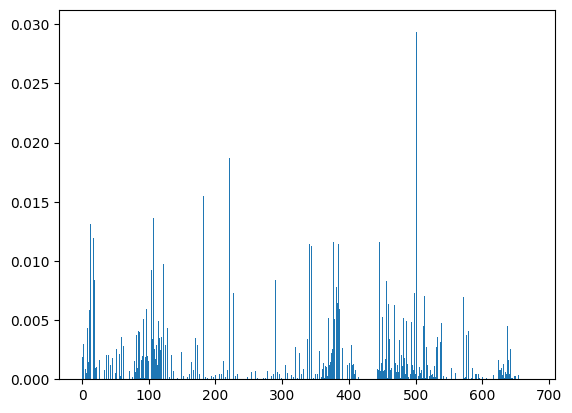

In [39]:
# Here is an example of the frequency of each of the letter combinations (676 in total) for the English model
names = list(english_model_ordered.keys())
values = list(english_model_ordered.values())

plt.bar(range(len(english_model_ordered)), values)
plt.show()

#### Joint probabilities

We use the frequencies of each letter pair possibility and put together all those that are permutations of each other to generate a dictionary with all the joint probabilities.

In [40]:
def joint_prob(model_bigram):
    joint = dict()
    keys_list = list(model_bigram.keys())
    for item in keys_list:
        if item[0] != item[1]:
            joint[item] = (model_bigram[item] + model_bigram[item[::-1]])/2
        else:
            joint[item] = model_bigram[item]
    return joint

joint_english = joint_prob(english_model_ordered) # These are the joint probabilities
joint_spanish = joint_prob(spanish_model_ordered)

With this we can measure the effectiveness of the model on the test data.

In [41]:
def log_likelihood(string:str, probs:dict):
    result = 0.0
    parts = []
    for i in range(len(string)-1):
        parts.append(string[i:i+2])
    for pair in parts:
        if probs[pair] != 0:
            result = result + log(probs[pair])
    return result

In [42]:
en = pd.read_csv(os.path.join("Test", "English_test.csv"))["Text"]
correct_english = 0
total_english = en.size
for row in en.items():
    english = log_likelihood(clean_string(row[1]), joint_english)
    spanish = log_likelihood(clean_string(row[1]), joint_spanish)
    if english > spanish:
        correct_english += 1
print(f"Model(simple joint probabilities) hits on test examples labeled as English: {correct_english/total_english}")

Model(simple joint probabilities) hits on test examples labeled as English: 0.9415162454873646


In [43]:
en = pd.read_csv(os.path.join("Test", "Spanish_test.csv"))["Text"]
correct_spanish = 0
total_spanish = en.size
for row in en.items():
    english = log_likelihood(clean_string(row[1]), joint_english)
    spanish = log_likelihood(clean_string(row[1]), joint_spanish)
    if english < spanish:
        correct_spanish += 1
print(f"Model(simple joint probabilities) hits on test examples labeled as Spanish: {correct_spanish/total_spanish}")

Model(simple joint probabilities) hits on test examples labeled as Spanish: 0.9181929181929182


#### Conditional probabilities
Finally, we can use our joint probabilities and individual (or marginal) probabilities to generate a slightly more realistic model with conditional probabilities.
$$P(X|Y) = \frac{P(X,Y)}{P(Y)}$$

In [44]:
def log_likelihood_contional(string:str, dist_1:dict, dist_2:dict):
    result = 0.0
    parts = []
    for i in range(len(string)-1):
        parts.append(string[i:i+2])
    for pair in parts:
        if dist_1[pair] != 0:
            result = result + log(dist_1[pair]/dist_2[pair[0]])
    return result

#### Testing for the conditional probabilities (Bigram model)

In [45]:
en = pd.read_csv(os.path.join("Test", "English_test.csv"))["Text"]
correct_english = 0
total_english = en.size
for row in en.items():
    english = log_likelihood_contional(clean_string(row[1]), joint_english, english_model)
    spanish = log_likelihood_contional(clean_string(row[1]), joint_spanish, spanish_model)
    if english > spanish:
        correct_english += 1
print(f"Model(conditional probabilities) hits on test examples labeled as English: {correct_english/total_english}")

Model(conditional probabilities) hits on test examples labeled as English: 0.9487364620938629


In [46]:
en = pd.read_csv(os.path.join("Test", "Spanish_test.csv"))["Text"]
correct_spanish = 0
total_spanish = en.size
for row in en.items():
    english = log_likelihood_contional(clean_string(row[1]), joint_english, english_model)
    spanish = log_likelihood_contional(clean_string(row[1]), joint_spanish, spanish_model)
    if english < spanish:
        correct_spanish += 1
print(f"Model(simple joint probabilities) hits on test examples labeled as Spanish: {correct_spanish/total_spanish}")

Model(simple joint probabilities) hits on test examples labeled as Spanish: 0.9536019536019537


#### Conclusions

Building a model using conditional probabilities allowed for improved prediction performance compared to the joint probability model, and is a slightly more realistic approach to the metrics used for natural language processing.